In [2]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi,log
import matplotlib as mpl

# import basic plot tools
from qiskit.visualization import plot_histogram

# map to Statevector
from qiskit.quantum_info import Statevector


# Quantum Assignment

The goal of the assignment is to take the code we wrote in the previous class and convert it into Sticky Walk. Since the coin and shift operator are already implemented, all you need to do is add the oracle and modify a few function calls. 

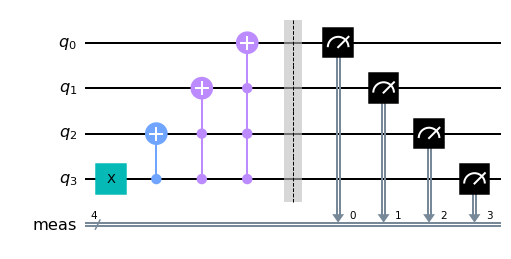

In [3]:
# qubit incrementation

# arg: n_adder is the number of qubits to be incremented

def increment(n_adder):
    
    qc = QuantumCircuit(n_adder)
    
    for i in range(n_adder-2):
        qc.mcx(list(range(i+1, n_adder)),i)
    
    qc.cx(n_adder-1, n_adder-2)
    qc.x(n_adder-1)
    
    U_inc = qc.to_gate()
    U_inc.name = "U$_{inc}$"
    
    return U_inc


def decrement(n_sub):
    
    qc = QuantumCircuit(n_sub)
    
    qc.x(n_sub-1)
    qc.cx(n_sub-1, n_sub-2)
    
    for i in range(n_sub-3, -1, -1):
        qc.mcx(list(range(i+1, n_sub)),i)
               
    U_dec = qc.to_gate()
    U_dec.name = "U$_{dec}$"
    
    return U_dec

qc = QuantumCircuit(4)

qc.append(decrement(4), [0,1,2,3])
qc.measure_all()

qc.decompose().draw('mpl')

In [4]:
def shift(n_dir, n_pos):
    
    half_n = math.ceil(n_pos/2)
    
    qr = QuantumRegister(n_dir+n_pos)
    q_dir = qr[:n_dir]
    q_pos = qr[n_dir:]
    
    qc = QuantumCircuit(qr)
    
    # if direction is 00 (RIGHT), increment right-most qubits
    qc.x(q_dir)
    qc.append(increment(half_n).control(2), q_dir+q_pos[half_n:])
    qc.x(q_dir)
    
    # if direction is 01 (DOWN), increment left-most qubits
    qc.x(q_dir[0])
    qc.append(increment(half_n).control(2), q_dir+q_pos[:half_n])
    qc.x(q_dir[0])
    
    # if direction is 10 (LEFT), decrement right-most qubits
    qc.x(q_dir[1])
    qc.append(decrement(half_n).control(2), q_dir+q_pos[half_n:])
    qc.x(q_dir[1])
    
    # if direction is 11 (UP), increment left-most qubits
    qc.append(decrement(half_n).control(2), q_dir+q_pos[:half_n])
    
    
    U_shift = qc.to_gate()
    U_shift.name = "U$_{shift}$"
    return U_shift

## Hints and help


The above (increment, decrement, and shift) do not need to be touched. The only code you will need to add / change is in the code of the walk itself. Please add/edit code in the commented location.

In [12]:
n_dir = 2 # number of qubits required to represent all directions
n_pos = 6 # number of qubits required to represent all positions
iterations = 10

''' +1 added for ancilla. The ancilla qubit is set to |1> if |pos> is a target state,
    |0> otherwise. '''
qwalk_reg = QuantumRegister(n_dir+n_pos+1)

# allocating qubits
q_dir = qwalk_reg[:n_dir]
q_pos = qwalk_reg[n_dir:n_dir+n_pos]
q_anc = qwalk_reg[n_dir+n_pos]

# lists of indices
dir_ind = list(range(n_dir)) # [0,1]
pos_ind = list(range(n_dir+n_pos))[n_dir:] # [2,3,4,5,6,7]
anc_ind = n_dir+n_pos # 8

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# starting state 010100
qwalk_circ.x(3)
qwalk_circ.x(5)
qwalk_circ.barrier()


# Add state harvesting
states = []

# setup iterations
for i in range(iterations):
    
    states.append(Statevector.from_instruction(qwalk_circ))
    
    # apply Hadamard coin
    for qubit in q_dir:
        qwalk_circ.h(qubit)
        
    ''' WRITE YOUR ORACLE HERE. You do not need to write a separate function.
        This will be a boolean oracle. (NOT A PHASE ORACLE)
        The target state is 1111. Use this information to set the ancilla accordingly.'''
    
    ''' END OF ORACLE'''
    
    '''Modify the shift operator call so that the walker only takes a step
       if they are not in a target state. ie. if in a target state, no shift
       is applied. '''
    # apply Shift operator
    qwalk_circ.append(shift(n_dir, n_pos), q_dir+q_pos)

states.append(Statevector.from_instruction(qwalk_circ))
qwalk_circ.barrier()

# measure position qubits only
qwalk_circ.measure(pos_ind, list(range(n_pos))[::-1]) # reversed to print in Big Endian form

# qwalk_circ.draw('mpl')

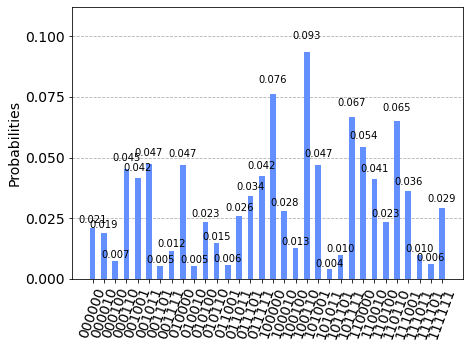

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(qwalk_circ, aer_sim)
qobj = assemble(transpiled_circuit)
results = aer_sim.run(qobj, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

Position qubits: {'010100': 1.0}
Data: [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


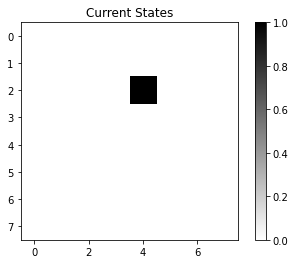

Position qubits: {'001100': 0.25, '010011': 0.25, '010101': 0.25, '011100': 0.25}
Data: [[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


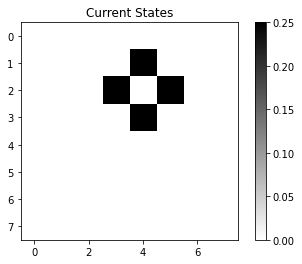

Position qubits: {'000100': 0.0625, '001011': 0.125, '001101': 0.125, '010010': 0.0625, '010100': 0.25, '010110': 0.0625, '011011': 0.125, '011101': 0.125, '100100': 0.0625}
Data: [[0.     0.     0.     0.     0.0625 0.     0.     0.    ]
 [0.     0.     0.     0.125  0.     0.125  0.     0.    ]
 [0.     0.     0.0625 0.     0.25   0.     0.0625 0.    ]
 [0.     0.     0.     0.125  0.     0.125  0.     0.    ]
 [0.     0.     0.     0.     0.0625 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.    ]]


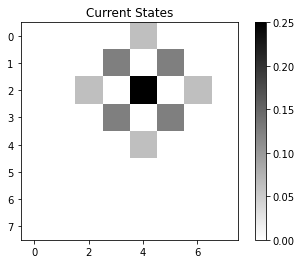

Position qubits: {'000011': 0.01562, '000101': 0.07812, '001010': 0.07812, '001100': 0.07812, '001110': 0.07812, '010001': 0.01562, '010011': 0.07812, '010101': 0.01562, '010111': 0.01562, '011010': 0.01562, '011100': 0.39062, '011110': 0.07812, '100011': 0.01562, '100101': 0.01562, '101100': 0.01562, '111100': 0.01562}
Data: [[0.      0.      0.      0.01562 0.      0.07812 0.      0.     ]
 [0.      0.      0.07812 0.      0.07812 0.      0.07812 0.     ]
 [0.      0.01562 0.      0.07812 0.      0.01562 0.      0.01562]
 [0.      0.      0.01562 0.      0.39062 0.      0.07812 0.     ]
 [0.      0.      0.      0.01562 0.      0.01562 0.      0.     ]
 [0.      0.      0.      0.      0.01562 0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.01562 0.      0.      0.     ]]


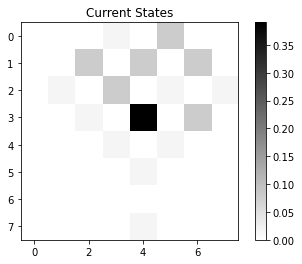

Position qubits: {'000010': 0.00781, '000100': 0.01562, '000110': 0.07031, '001001': 0.03906, '001011': 0.10937, '001101': 0.04687, '001111': 0.03906, '010000': 0.00781, '010010': 0.01562, '010100': 0.07812, '010110': 0.01562, '011001': 0.00781, '011011': 0.04687, '011101': 0.35937, '011111': 0.03906, '100010': 0.00781, '100100': 0.01562, '100110': 0.00781, '101011': 0.00781, '101101': 0.00781, '110100': 0.00781, '111011': 0.00781, '111101': 0.03906}
Data: [[0.      0.      0.00781 0.      0.01562 0.      0.07031 0.     ]
 [0.      0.03906 0.      0.10937 0.      0.04687 0.      0.03906]
 [0.00781 0.      0.01562 0.      0.07812 0.      0.01562 0.     ]
 [0.      0.00781 0.      0.04687 0.      0.35937 0.      0.03906]
 [0.      0.      0.00781 0.      0.01562 0.      0.00781 0.     ]
 [0.      0.      0.      0.00781 0.      0.00781 0.      0.     ]
 [0.      0.      0.      0.      0.00781 0.      0.      0.     ]
 [0.      0.      0.      0.00781 0.      0.03906 0.      0.     ]]


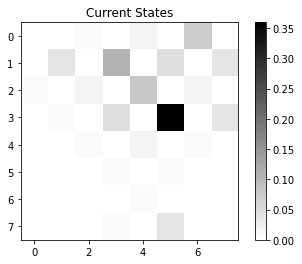

Position qubits: {'000001': 0.00391, '000011': 0.01953, '000101': 0.03516, '000111': 0.05078, '001000': 0.03516, '001010': 0.08203, '001100': 0.04687, '001110': 0.01953, '010001': 0.00391, '010011': 0.04687, '010101': 0.07812, '010111': 0.02734, '011000': 0.01953, '011010': 0.01953, '011100': 0.07812, '011110': 0.16016, '100001': 0.00391, '100011': 0.00391, '100101': 0.16016, '100111': 0.00391, '101010': 0.00391, '101100': 0.00391, '101110': 0.00391, '110011': 0.01172, '110101': 0.01953, '111010': 0.00391, '111100': 0.00391, '111110': 0.05078}
Data: [[0.      0.00391 0.      0.01953 0.      0.03516 0.      0.05078]
 [0.03516 0.      0.08203 0.      0.04687 0.      0.01953 0.     ]
 [0.      0.00391 0.      0.04687 0.      0.07812 0.      0.02734]
 [0.01953 0.      0.01953 0.      0.07812 0.      0.16016 0.     ]
 [0.      0.00391 0.      0.00391 0.      0.16016 0.      0.00391]
 [0.      0.      0.00391 0.      0.00391 0.      0.00391 0.     ]
 [0.      0.      0.      0.01172 0.      

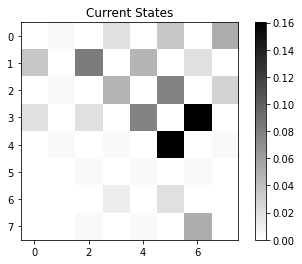

Position qubits: {'000000': 0.02637, '000010': 0.05859, '000100': 0.00684, '000110': 0.03516, '001001': 0.05078, '001011': 0.01758, '001101': 0.04883, '001111': 0.00391, '010000': 0.03516, '010010': 0.03809, '010100': 0.04687, '010110': 0.01465, '011001': 0.01953, '011011': 0.01758, '011101': 0.14258, '011111': 0.05078, '100000': 0.01074, '100010': 0.00391, '100100': 0.0459, '100110': 0.10547, '101001': 0.00195, '101011': 0.00391, '101101': 0.08203, '101111': 0.00195, '110010': 0.00293, '110100': 0.00391, '110110': 0.03418, '111001': 0.00195, '111011': 0.01953, '111101': 0.01953, '111111': 0.04883}
Data: [[0.02637 0.      0.05859 0.      0.00684 0.      0.03516 0.     ]
 [0.      0.05078 0.      0.01758 0.      0.04883 0.      0.00391]
 [0.03516 0.      0.03809 0.      0.04687 0.      0.01465 0.     ]
 [0.      0.01953 0.      0.01758 0.      0.14258 0.      0.05078]
 [0.01074 0.      0.00391 0.      0.0459  0.      0.10547 0.     ]
 [0.      0.00195 0.      0.00391 0.      0.08203 0. 

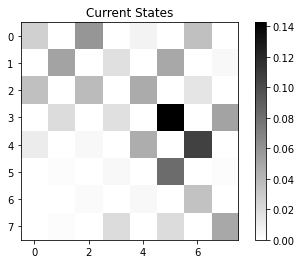

Position qubits: {'000001': 0.07642, '000011': 0.01782, '000101': 0.0188, '000111': 0.02173, '001000': 0.02173, '001010': 0.01685, '001100': 0.0188, '001110': 0.02466, '010001': 0.02759, '010011': 0.04419, '010101': 0.04321, '010111': 0.02368, '011000': 0.01587, '011010': 0.01782, '011100': 0.01392, '011110': 0.02271, '100001': 0.01099, '100011': 0.01782, '100101': 0.24048, '100111': 0.08423, '101000': 0.00317, '101010': 0.00122, '101100': 0.02173, '101110': 0.03247, '110001': 0.00024, '110011': 0.00806, '110101': 0.01587, '110111': 0.04419, '111000': 0.03735, '111010': 0.02271, '111100': 0.00024, '111110': 0.03345}
Data: [[0.0000e+00 7.6420e-02 0.0000e+00 1.7820e-02 0.0000e+00 1.8800e-02
  0.0000e+00 2.1730e-02]
 [2.1730e-02 0.0000e+00 1.6850e-02 0.0000e+00 1.8800e-02 0.0000e+00
  2.4660e-02 0.0000e+00]
 [0.0000e+00 2.7590e-02 0.0000e+00 4.4190e-02 0.0000e+00 4.3210e-02
  0.0000e+00 2.3680e-02]
 [1.5870e-02 0.0000e+00 1.7820e-02 0.0000e+00 1.3920e-02 0.0000e+00
  2.2710e-02 0.0000e+00

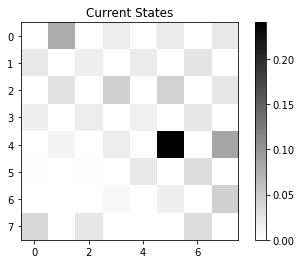

Position qubits: {'000000': 0.02563, '000010': 0.07056, '000100': 0.01196, '000110': 0.02075, '001001': 0.03394, '001011': 0.00952, '001101': 0.02222, '001111': 0.0105, '010000': 0.02173, '010010': 0.00806, '010100': 0.04419, '010110': 0.06079, '011001': 0.0105, '011011': 0.0144, '011101': 0.02124, '011111': 0.0105, '100000': 0.06665, '100010': 0.00903, '100100': 0.02563, '100110': 0.24634, '101001': 0.00269, '101011': 0.0105, '101101': 0.03394, '101111': 0.03687, '110000': 0.04419, '110010': 0.0061, '110100': 0.01001, '110110': 0.02368, '111001': 0.03296, '111011': 0.0105, '111101': 0.0105, '111111': 0.03394}
Data: [[0.02563 0.      0.07056 0.      0.01196 0.      0.02075 0.     ]
 [0.      0.03394 0.      0.00952 0.      0.02222 0.      0.0105 ]
 [0.02173 0.      0.00806 0.      0.04419 0.      0.06079 0.     ]
 [0.      0.0105  0.      0.0144  0.      0.02124 0.      0.0105 ]
 [0.06665 0.      0.00903 0.      0.02563 0.      0.24634 0.     ]
 [0.      0.00269 0.      0.0105  0.     

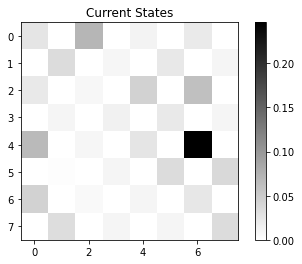

Position qubits: {'000001': 0.06299, '000011': 0.00928, '000101': 0.02979, '000111': 0.021, '001000': 0.01025, '001010': 0.05127, '001100': 0.02026, '001110': 0.00537, '010001': 0.01709, '010011': 0.02417, '010101': 0.0022, '010111': 0.06494, '011000': 0.01123, '011010': 0.00928, '011100': 0.02954, '011110': 0.03955, '100001': 0.04932, '100011': 0.00928, '100101': 0.05127, '100111': 0.1499, '101000': 0.0437, '101010': 0.00537, '101100': 0.01025, '101110': 0.08643, '110001': 0.02563, '110011': 0.01416, '110101': 0.00146, '110111': 0.05542, '111000': 0.01392, '111010': 0.03955, '111100': 0.01123, '111110': 0.0249}
Data: [[0.      0.06299 0.      0.00928 0.      0.02979 0.      0.021  ]
 [0.01025 0.      0.05127 0.      0.02026 0.      0.00537 0.     ]
 [0.      0.01709 0.      0.02417 0.      0.0022  0.      0.06494]
 [0.01123 0.      0.00928 0.      0.02954 0.      0.03955 0.     ]
 [0.      0.04932 0.      0.00928 0.      0.05127 0.      0.1499 ]
 [0.0437  0.      0.00537 0.      0.010

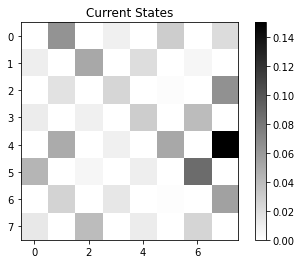

Position qubits: {'000000': 0.02301, '000010': 0.02197, '000100': 0.00665, '000110': 0.04932, '001001': 0.03662, '001011': 0.04187, '001101': 0.00378, '001111': 0.01514, '010000': 0.05127, '010010': 0.00543, '010100': 0.02417, '010110': 0.01349, '011001': 0.00928, '011011': 0.02576, '011101': 0.03894, '011111': 0.03662, '100000': 0.07208, '100010': 0.02979, '100100': 0.01227, '100110': 0.09229, '101001': 0.04285, '101011': 0.00342, '101101': 0.01318, '101111': 0.05945, '110000': 0.05542, '110010': 0.03595, '110100': 0.02783, '110110': 0.06696, '111001': 0.04089, '111011': 0.01318, '111101': 0.00537, '111111': 0.02576}
Data: [[0.02301 0.      0.02197 0.      0.00665 0.      0.04932 0.     ]
 [0.      0.03662 0.      0.04187 0.      0.00378 0.      0.01514]
 [0.05127 0.      0.00543 0.      0.02417 0.      0.01349 0.     ]
 [0.      0.00928 0.      0.02576 0.      0.03894 0.      0.03662]
 [0.07208 0.      0.02979 0.      0.01227 0.      0.09229 0.     ]
 [0.      0.04285 0.      0.00342

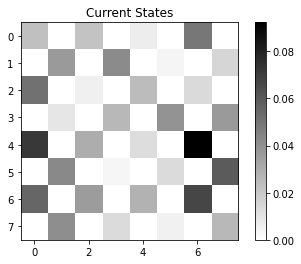

In [10]:
def round_remove_zeroes(np_dict):
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            d[k] = round(v, 5)
    
    new_dict = {}
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            if v:
                new_dict[k] = v
                
    return new_dict

# PLOTTING FOR 8 x 8 GRID
sum_data = np.zeros((8,8))
meta_states = []

for state in states:
    
    np_dict = round_remove_zeroes(np.array(state.probabilities_dict([7,6,5,4,3,2])))         
    print("Position qubits:",np_dict)
    
    data = np.around(np.array(state.probabilities([7,6,5,4,3,2])), 5)
    data = np.reshape(data, (8,8))
    sum_data = sum_data + data
    meta_states.append(sum_data)
    d = state.probabilities_dict([7,6,5,4,3,2])
    
    # customizing plot
    plt.title("Current States")
    pixel_plot = plt.imshow(
      data, cmap='binary')

    plt.colorbar(pixel_plot)
    
    print("Data:",data)
    plt.show(pixel_plot)
    
